In [4]:
from os import listdir, walk
from os.path import isfile, join
import numpy as np
from PIL import Image
import time
import cv2
from sys import getsizeof
from IPython.display import display
import random
import math
import datetime
import sys
from tensorflow.keras.optimizers import *
import operator

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#tf.config.optimizer.set_jit(True)
#tf.debugging.set_log_device_placement(True)
print(tf.config.experimental.list_physical_devices())

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
VALIDATION_STEPS = 30


%run ./variables.ipynb
%run ./utils.ipynb
%run ../utils/data_utils.ipynb

id_map = get_selected_taxons("../../selected_taxons.txt")
id_map_inv = get_selected_taxons("../../selected_taxons.txt", inv=True)
n_classes = len(list(id_map.keys()))

tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

# Handle data

## Data generator

In [5]:
# Sampling the dataset to fit the ImageDataGenerator
files, _, _ = get_dataset()
sample_files = np.random.permutation(files)[0:int(0.4*len(files))]
new_size = 50
#fit_dataset = np.array([cv2.resize(cv2.imread(file), dsize=(new_size, new_size), interpolation=cv2.INTER_CUBIC) for file in sample_files])
fit_dataset = np.array([cv2.imread(file) for file in sample_files]).astype("float32")
del files, sample_files
print(fit_dataset.shape)

'171/171'

ValueError: too many values to unpack (expected 2)

In [3]:
datagen = ImageDataGenerator(rescale=1./255.,
                         rotation_range=90, 
                         brightness_range=[0.8,1.2], 
                         horizontal_flip=True, 
                         vertical_flip=True,
                         fill_mode='nearest',
                         width_shift_range=40,
                         height_shift_range=40,
                         zoom_range=0.2,
                         validation_split=0.2,
                         #featurewise_std_normalization=True,
                         data_format="channels_last") 
#datagen.fit(fit_dataset)
del fit_dataset

## Setting up the flows

In [4]:
# Retrieving id array
size = max(id_map.items(), key=operator.itemgetter(1))[1]
classes_array = [None]*(size+1)
for el in id_map:
    classes_array[id_map[el]]=el
classes_array[0]="DUST"

In [5]:
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    classes=classes_array,
    batch_size=BATCH_SIZE,
    subset="training",
    seed=27)
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    classes=classes_array,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=27)

train_spe = train_generator.samples // BATCH_SIZE
val_spe = val_generator.samples // BATCH_SIZE

Found 4990 images belonging to 230 classes.
Found 1154 images belonging to 230 classes.


## Testing

193


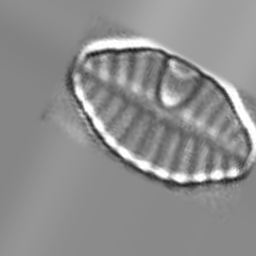

In [6]:
i = 0
stop = False
for batch in train_generator:
    images = batch[0]
    labels = batch[1]
    for i in range(images.shape[0]):
        print(np.argmax(labels[i]))
        image = (images[i,:,:,:]*255).astype('uint8')
        #print(image)
        display(Image.fromarray(image))
        i+=1
        if i>=1:
            stop = True
            break
    if stop: break;
    #display()

# Model desgin

In [7]:
# fetching base model
#base_model = Xception(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling=None)
input_tensor = Input(shape=(256, 256, 3))
base_model = InceptionV3(weights='imagenet', input_tensor=input_tensor, include_top=False)

In [8]:
# setting model for specifiv case
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
out = Dense(230, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Training

In [9]:
# Setting tensorboard
!rm -rf LOG_DIR
log_dir = LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## New layers only

In [10]:
n_epochs_train1 = 3

print(n_epochs_train1, "epochs composed of", train_spe, "batches (steps) of", BATCH_SIZE, "images.")

for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.fit(train_generator, 
          epochs=n_epochs_train1, 
          steps_per_epoch=train_spe,
          use_multiprocessing=True, 
          validation_data=val_generator,
          validation_steps=val_spe,
          callbacks=[tensorboard_callback],
          initial_epoch=0)

3 epochs composed of 155 batches (steps) of 32 images.
Train for 155 steps, validate for 36 steps
Epoch 1/3
155/155 [==============================] - 121s 780ms/step - loss: 4.0959 - accuracy: 0.1759 - val_loss: 4.3433 - val_accuracy: 0.0833
Epoch 2/3
155/155 [==============================] - 122s 788ms/step - loss: 2.5276 - accuracy: 0.3957 - val_loss: 4.6575 - val_accuracy: 0.0938
Epoch 3/3
155/155 [==============================] - 119s 767ms/step - loss: 1.9062 - accuracy: 0.4986 - val_loss: 4.8257 - val_accuracy: 0.1016


## Training 2 last inceptions blocks

In [11]:
n_epochs_train2 = n_epochs_train1+10

print(n_epochs_train2, "epochs composed of", train_spe, "batches (steps) of", BATCH_SIZE, "images.")

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_generator, 
          epochs=n_epochs_train2, 
          steps_per_epoch=train_spe,
          use_multiprocessing=True, 
          validation_data=val_generator,
          validation_steps=val_spe,
          callbacks=[tensorboard_callback],
          initial_epoch=n_epochs_train1)

13 epochs composed of 155 batches (steps) of 32 images.
Train for 155 steps, validate for 36 steps
Epoch 4/13
155/155 [==============================] - 121s 780ms/step - loss: 1.6913 - accuracy: 0.5226 - val_loss: 7.8049 - val_accuracy: 0.1345
Epoch 5/13
155/155 [==============================] - 123s 790ms/step - loss: 1.0206 - accuracy: 0.6910 - val_loss: 5.4755 - val_accuracy: 0.2248
Epoch 6/13
155/155 [==============================] - 121s 778ms/step - loss: 0.7891 - accuracy: 0.7455 - val_loss: 5.3557 - val_accuracy: 0.2127
Epoch 7/13
155/155 [==============================] - 120s 772ms/step - loss: 0.6578 - accuracy: 0.7941 - val_loss: 6.3772 - val_accuracy: 0.1649
Epoch 8/13
155/155 [==============================] - 120s 773ms/step - loss: 0.5683 - accuracy: 0.8130 - val_loss: 5.0739 - val_accuracy: 0.1988
Epoch 9/13
155/155 [==============================] - 120s 777ms/step - loss: 0.5007 - accuracy: 0.8320 - val_loss: 4.9401 - val_accuracy: 0.2283
Epoch 10/13
155/155 [====

## Training full model

In [12]:
n_epochs_train3 = n_epochs_train2+40

print(n_epochs_train2, "epochs composed of", train_spe, "batches (steps) of", BATCH_SIZE, "images.")

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_generator, 
          epochs=n_epochs_train3, 
          steps_per_epoch=train_spe,
          use_multiprocessing=True, 
          validation_data=val_generator,
          validation_steps=val_spe,
          callbacks=[tensorboard_callback],
          initial_epoch=n_epochs_train2)

13 epochs composed of 155 batches (steps) of 32 images.
Train for 155 steps, validate for 36 steps
Epoch 14/53
155/155 [==============================] - 133s 857ms/step - loss: 1.6745 - accuracy: 0.5456 - val_loss: 3.8583 - val_accuracy: 0.2578
Epoch 15/53
155/155 [==============================] - 130s 838ms/step - loss: 0.9225 - accuracy: 0.7136 - val_loss: 2.4605 - val_accuracy: 0.4097
Epoch 16/53
155/155 [==============================] - 125s 805ms/step - loss: 0.7469 - accuracy: 0.7683 - val_loss: 3.1143 - val_accuracy: 0.3594
Epoch 17/53
155/155 [==============================] - 128s 823ms/step - loss: 0.6638 - accuracy: 0.7812 - val_loss: 2.2899 - val_accuracy: 0.4878
Epoch 18/53
155/155 [==============================] - 128s 823ms/step - loss: 0.5729 - accuracy: 0.8114 - val_loss: 1.7264 - val_accuracy: 0.5590
Epoch 19/53
155/155 [==============================] - 131s 847ms/step - loss: 0.5182 - accuracy: 0.8296 - val_loss: 4.1171 - val_accuracy: 0.3698
Epoch 20/53
155/155

## Saving model

In [13]:
model_json = model.save_weights("./saved_models/model.h5")
model_json = model.to_json()
with open("./saved_models/model.json", "w") as json_file:
    json_file.write(model_json)
    
    # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
